In [0]:
#@title Colab Specifications
%matplotlib inline
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
#@title Mount at Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks')
print()
print(f"Current directory : {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Current directory : /content/drive/My Drive/Colab Notebooks


In [0]:
#@title Data preprocessing

import tensorflow as tf
import tensorflow_datasets as tfds
from pathlib import Path

tfds.disable_progress_bar()

DATASET = "mnist" #@param ["mnist", "fashion_mnist", "cifar10"] {allow-input: true}

# load dataset
tf_dataset, info = tfds.load(DATASET, split="train", batch_size=-1, with_info=True)
np_dataset = tfds.as_numpy(tf_dataset)
train_images, train_labels = np_dataset["image"].astype('float32'), np_dataset["label"]
train_images = (train_images - 127.5) / 127.5

PATHS = [
         'plots/%s/WGAN/' % DATASET.upper(),
         'models/%s/WGAN/' % DATASET.upper(),
         'logs/%s/WGAN/' % DATASET.upper()      
          ]
for path in PATHS:
    Path(path).mkdir(parents=True, exist_ok=True)


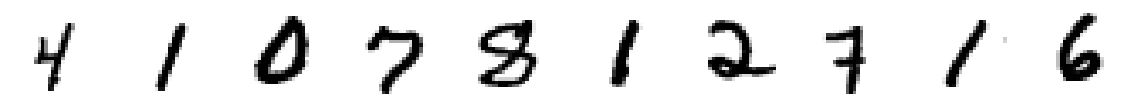

In [0]:
#@title Data Visualization

from matplotlib import pyplot
from pylab import rcParams

PLOT_SIZE = 20 #@param {type:"integer"}

rcParams['figure.figsize'] = PLOT_SIZE, PLOT_SIZE

VIS_LINES = 1 #@param {type:"integer"}
VIS_ROWS = 10 #@param {type:"integer"}

# plot images from the training dataset
for i in range(VIS_LINES*VIS_ROWS):
    # define subplot
    pyplot.subplot(VIS_LINES, VIS_ROWS, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(tf.squeeze((train_images[i] + 1) / 2), cmap='gray_r')
pyplot.show()

In [0]:
#@title Best WGAN Model

from tensorflow.keras.models import Sequential, Model

class WGAN(Model):
    """
    Honestly, the best way to implement a model
    """

    def __init__(self, **kwargs):
        """
        initialize model with its super's features and methods
        """

        super(WGAN, self).__init__()
        self.__dict__.update(kwargs)
        self.gen = Sequential(self.gen)
        self.disc = Sequential(self.disc)

    @tf.function
    def generate(self, z):
        """
        passes through the generator network
        """

        return self.gen(z)

    @tf.function
    def discrimenate(self, x):
        """
        passes through the discrimenator network
        """

        return self.disc(x)

    @tf.function
    def compute_disc_loss(self, x, batch_size):
        """
        passes through the network and computes loss
        """

        # generating noise from a uniform distribution
        z_samp = tf.random.normal([batch_size, 1, 1, self.z_size])
        # run noise through generator
        x_gen = self.generate(z_samp)
        # discrimenate x and x_gen
        logits_x = self.discrimenate(x)
        logits_x_gen = self.discrimenate(x_gen)
        # pondered loss : note that logits_x are multipied by 1 and logits_x_gen are multiplied by -1, e.g. wasserstein loss
        disc_loss = (tf.reduce_mean(logits_x) - tf.reduce_mean(logits_x_gen))

        return disc_loss
    
    @tf.function
    def compute_gen_loss(self, batch_size):
        """
        passes through the network and computes loss
        """

        # generating noise from a uniform distribution
        z_samp = tf.random.normal([batch_size, 1, 1, self.z_size])
        # run noise through generator
        x_gen = self.generate(z_samp)
        # discrimenate x_gen
        logits_x_gen = self.discrimenate(x_gen)
        # losses of fake with label "1"
        gen_loss = tf.reduce_mean(logits_x_gen)

        return gen_loss

    @tf.function
    def compute_disc_gradients(self, x, batch_size):
        """
        passes through the network and computes loss
        """

        ### compute loss
        with tf.GradientTape() as disc_tape:
            disc_loss = self.compute_disc_loss(x, batch_size)
            # compute gradients
            disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return disc_gradients, disc_loss
    
    @tf.function
    def compute_gen_gradients(self, batch_size):
        """
        passes through the network and computes loss
        """

        ### compute loss
        with tf.GradientTape() as gen_tape:
            gen_loss = self.compute_gen_loss(batch_size)
            # compute gradients
            gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        
        return gen_gradients, gen_loss

    @tf.function
    def train_disc(self, train_x, batch_size):

        # calculate gradients and loss
        disc_gradients, disc_loss = self.compute_disc_gradients(train_x, batch_size)
        # apply gradients
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.disc.trainable_variables))
        
        return disc_loss
    
    @tf.function
    def train_gen(self, batch_size):

        # calculate gradients and loss
        gen_gradients, gen_loss = self.compute_gen_gradients(batch_size)
        # apply gradients
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.gen.trainable_variables))
        
        return gen_loss

In [0]:
#@title Defining the Generator and the Discrimenator sub-models

from tensorflow.keras.layers import UpSampling2D, Conv2D, BatchNormalization, \
                                    Activation, ZeroPadding2D, Input, Dense,  \
                                    Reshape, Flatten, Dropout, LeakyReLU, Add

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.constraints import Constraint

UP_SAMPLING_LAYERS = 2 #@param {type:"integer"}
INIT_KERNELS = 128 #@param {type:"integer"}
Z_SIZE = 100    #@param {type:"integer"}

DIMS = train_images[0].shape
IMAGE_CHANNELS = DIMS[2]
INIT_IMAGE_SIZE = int(DIMS[0] / 2**UP_SAMPLING_LAYERS)


# clip model weights to a given hypercube
class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
        return tf.clip_by_value(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}

const = ClipConstraint(0.01)
init = RandomNormal(stddev=0.02)

generator =[]

generator.extend([ # explode dimensionality
                   Flatten(),
                   Dense(INIT_KERNELS * INIT_IMAGE_SIZE * INIT_IMAGE_SIZE, activation="relu", input_dim=Z_SIZE, kernel_initializer=init),
                   Reshape((INIT_IMAGE_SIZE, INIT_IMAGE_SIZE, INIT_KERNELS))
                   ])

for i in range(UP_SAMPLING_LAYERS):
    generator.extend([ # augment resolution x2
                      UpSampling2D(),
                      Conv2D(int(INIT_KERNELS / 2**i), kernel_size=5, padding="same", kernel_initializer=init),
                      BatchNormalization(momentum=0.8),
                      Activation("relu")
                      ])

generator.extend([ # compose final image
                   Conv2D(IMAGE_CHANNELS, kernel_size=5, padding="same", kernel_initializer=init),
                   Activation("tanh")
                   ])

discrimenator = [ # convolution block 1
                  Conv2D(16, kernel_size=3, strides=2, padding="same", kernel_constraint=const, kernel_initializer=init, input_shape=DIMS),
                  BatchNormalization(momentum=0.8),
                  LeakyReLU(alpha=0.2),
                  Dropout(0.25),
                  # convolution block 2
                  Conv2D(32, kernel_size=3, strides=2, padding="same", kernel_constraint=const, kernel_initializer=init),
                  ZeroPadding2D(padding=((0,1),(0,1))),
                  BatchNormalization(momentum=0.8),
                  LeakyReLU(alpha=0.2),
                  Dropout(0.25),
                  # convolution block 3
                  Conv2D(64, kernel_size=3, strides=2, padding="same", kernel_constraint=const, kernel_initializer=init),
                  BatchNormalization(momentum=0.8),
                  LeakyReLU(alpha=0.2),
                  Dropout(0.25),
                  # block 4
                  Conv2D(128, kernel_size=3, strides=1, padding="same", kernel_constraint=const, kernel_initializer=init),
                  BatchNormalization(momentum=0.8),
                  LeakyReLU(alpha=0.2),
                  Dropout(0.25),
                  Flatten(),
                  Dense(1, kernel_constraint=const, kernel_initializer=init)
                  ]

In [0]:
#@title Compile the model with its optimizers

from tensorflow.keras.optimizers import RMSprop, Adam

ALPHA = 0.00005 #@param {type:"number"}

# optimizers
gen_optimizer = RMSprop(lr=ALPHA)
disc_optimizer = RMSprop(lr=ALPHA)
# model
model = WGAN(name=f'WGAN_{DATASET.upper()}',
             gen = generator,
             disc = discrimenator,
             gen_optimizer = gen_optimizer,
             disc_optimizer = disc_optimizer,
             z_size = Z_SIZE
             )

In [0]:
#@title Third party functions for saving model and plots

from IPython.display import clear_output

SAVE_LINES = 10 #@param {type:"integer"}
SAVE_ROWS = 10 #@param {type:"integer"}

# evaluate the discrimenator, plot generated images, save generator model
def summarize_performance(epoch, model, losses):
    # a simple summerizing print
    print(f"Epoch: {epoch+1} | disc_loss: {losses.discrimenator_loss.values[-1]} | gen_loss: {losses.generator_loss.values[-1]}")
    # save plot
    save_plot(epoch, model)
    # save history
    save_history(losses)
    # save the model
    save_model(epoch, model)

# create and save a plot of generated images (reversed grayscale)
def save_plot(epoch, model, n_lines=SAVE_LINES, n_rows=SAVE_ROWS, z_size=Z_SIZE):
    # prepare noise
    noise = tf.random.normal(shape=(n_lines*n_rows, z_size))
    # generate images
    samples = model.generate(noise)
    # scale from [-1,1] to [0,1]
    samples = (samples + 1.) / 2.
    # prepare plot
    for i in range(n_lines * n_rows):
        # define subplot
        pyplot.subplot(n_lines, n_rows, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(tf.squeeze(samples[i, :, :, :]), cmap='gray_r')
    # save plot to file
    file_name = 'plots/%s/WGAN/WGAN_%s_plot_e%03d.png' % (DATASET.upper(), DATASET.upper(), epoch+1)
    pyplot.savefig(file_name)
    # pyplot.show()
    pyplot.close()

# save the whole model if possible xD
def save_model(epoch, model):
    file_name = 'models/%s/WGAN/WGAN_%s_model_e%03d.weights' % (DATASET.upper(), DATASET.upper(), epoch+1)
    model.save_weights(file_name)

def save_history(losses):
    # plot history
    pyplot.plot(losses.discrimenator_loss.values, label='discrimenator_loss')
    pyplot.plot(losses.generator_loss.values, label='generator_loss')
    pyplot.legend()
    pyplot.savefig('plots/%s/WGAN/WGAN_%s_loss_history.png' % (DATASET.upper(), DATASET.upper()))
    pyplot.close()


In [0]:
#@title Start training

import numpy as np
from tqdm import tqdm
from pandas import DataFrame

EPOCHS =  100   #@param {type:"integer"}
BATCH_SIZE = 64 #@param {type:"integer"}

TRAIN_BUF = len(train_images)
TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)

# a pandas dataframe to save the loss information to
losses = DataFrame(columns = ['discrimenator_loss', 'generator_loss'])

# iterate through epochs
for epoch in range(EPOCHS):
    # initiate loss counter
    loss = []
    # train through the dataset
    for batch in tqdm(range(TRAIN_BATCHES)):
        # take random indexes
        ix = np.random.randint(0, TRAIN_BUF, BATCH_SIZE)
        # select images
        train_x = train_images[ix]
        # train discriminator
        disc_loss = model.train_disc(train_x, BATCH_SIZE)
        # train generator
        gen_loss = model.train_gen(BATCH_SIZE)
        # 
        loss.append((disc_loss, gen_loss))
    
    # 
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # clear previous results
    clear_output()
    # plot new results
    summarize_performance(epoch, model, losses)


Epoch: 100 | disc_loss: 1.2097702040136937e-07 | gen_loss: 0.01941424421966076
